# Package Installation

## graph-tool installation

In [2]:
#on windows: 
#use the windows key
#type anaconda
#open the anaconda power prompt as ADMINISTRATOR (right click). 
#conda activate base
#conda create -n myenv python=3.8. 
#conda install -c conda-forge graph-tool

In [18]:
# check your python installation
import sys
sys.executable

'/Users/yil1/opt/anaconda3/envs/P2P/bin/python'

In [ ]:
from collections import Counter

In [19]:
def install_missing_packages(package_names):
    """
    Install Missing Packages

    This function checks if a list of packages is already installed and installs any missing packages using pip.

    Parameters:
    - package_names (list): A list of package names to be installed.

    Returns:
    - None

    Note: This function requires the `subprocess` and `importlib` modules to be imported.

    Example Usage:
    install_missing_packages(['h2o', 'numpy', 'pandas'])
    """
    import importlib
    import subprocess


    for package_name in package_names:
        try:
            importlib.import_module(package_name)
            print(f"{package_name} package is already installed")
        except ImportError:
            print(f"{package_name} package not found, installing with pip...")
            subprocess.call(['pip', 'install', package_name])


In [5]:
package_list = []
install_missing_packages(package_list)

# Functions

## First-satge data cleaning

In [6]:
'''
clean_data(df):
This code defines a function called `clean_data`, which takes a DataFrame (usually a DataFrame object in the pandas library) as input and performs a series of data cleaning operations on it. The specific cleaning steps are as follows:

1. **Delete missing values**: Use the `dropna()` method to remove rows containing missing values.

2. **Filter specific rows**: keep the rows whose `lang.1` column is equal to 1, and reset the index.

3. **Delete 'lang' column**: Delete all columns containing "lang".

4. **Delete Date Columns**: Delete `date.start` and `date.end` columns as they are considered irrelevant.

5. **Remove Look-Bias Variables**: Define a list containing look-ahead-bias variables and use the `drop()` method to drop those columns from the DataFrame.

6. **Delete Duplicate Income Variables**: Delete all columns that contain "inc." and do not contain ".no".

7. **Delete Dummy Variables**: Defines a list of dummy variables to delete and removes these columns from the DataFrame.

8. **Generate Correlation Matrix**: Use the `corr()` method to generate the correlation matrix of DataFrame.

9. **Choose the upper triangle of the correlation matrix**: To avoid multicollinearity, select the upper triangle of the correlation matrix.

10. **Find High Correlation Columns**: Find columns that have a correlation higher than 0.95 with other columns.

11. **Delete High Correlation Columns**: Delete the high correlation columns found in step 10.

Finally, the function returns the cleaned DataFrame.

The purpose of this code is to prepare the data for subsequent analysis or modeling. It cleans data by removing missing values, filtering specific rows, removing irrelevant or biased columns, and handling multicollinearity.

'''


# Import necessary libraries
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import random

# Define a function to calculate variance inflation factor (VIF) for all variables in a given DataFrame.
def calculate_vif(df):
    """Calculates variance inflation factor for all columns in df. It should contain 
    only exogeneous variables."""
    
    # Create an empty DataFrame
    vif = pd.DataFrame()
    
    # Calculate VIF for every column (variable) in the DataFrame
    vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    
    # Store column names
    vif["features"] = df.columns
    
    # Sort by VIF Factor in descending order
    vif = vif.sort_values("VIF Factor", ascending=False)
    return vif

# Define a function to clean the DataFrame, removing irrelevant and problematic features.
def clean_data(df):
    """
    Clean the given DataFrame, drop unnecessary columns, handle missing data, remove biased variables, 
    avoid multicollinearity by checking correlation, and keep only relevant columns.
    """
    
    # Drop rows with missing values
    df = df.dropna().reset_index(drop=True)

    # Filter for only rows where 'lang.1' equals 1, and drop 'lang' columns
    df = df[df["lang.1"] == 1].reset_index(drop=True)
    df = df.drop([x for x in df.columns if "lang" in x], axis=1)

    # Drop date columns as they are not considered relevant
    df = df.drop(["date.start", "date.end"], axis=1)

    # List of forward-looking biased variables
    fwl_bias = [
        "return",
        "RR1",
        "RR2.Mean",
        "RR2.Median",
        "RR2.WMean",
        "NPRP",
        "NPRA",
        "FVCI",
        "FVCI.Mean",
        "FVCI.Median",
        "FVCI.WMean",
    ]
    # Drop these forward-looking biased variables
    df = df.drop(fwl_bias, axis=1)

    # Drop duplicate income variables, keep only those with '.no' in name
    df = df.drop([x for x in df.columns if "inc." in x and ".no" in x], axis=1)

    # List of dummy variables to drop
    dummies_to_drop = ["AA", "educ.6", "em.dur.5p", "use.m", "ver.2", "Mining", "Utilities"]
    df = df.drop(dummies_to_drop, axis=1)

    # Generate a correlation matrix of the DataFrame
    corr_matrix = df.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    
    # Drop these columns from the DataFrame
    df = df.drop(df[to_drop], axis=1)

    return df

def create_balanced_sample(df, n, replace = False):
    """Create a balanced sample of size 2n from df. Ensures that the sample contains an equal number of instances for each class."""
    
    # Draw a random sample of size 'n' from the non-default class (default = 0) and from the default class (default = 1)
    # replace=True allows for resampling
    # Random state ensures reproducibility
    df_sample = pd.concat(
        [
            df[df["default"] == 0].sample(n=n, random_state=1, replace=replace),
            df[df["default"] == 1].sample(n=n, random_state=1, replace=replace),
        ]
    ).reset_index(drop=True)
    
    return df_sample


## Pands Numpy handling

In [7]:
import pandas as pd

def convert_to_category(df):
    """
    Convert columns with exactly two unique values to category type.
    
    Parameters:
        df (pandas.DataFrame): Input DataFrame to process.
        
    Returns:
        df (pandas.DataFrame): Processed DataFrame with columns converted to category type where applicable.
        category_columns (list): List of names of the columns that were converted to category type.
    """
    
    # Initialize a list to store the names of the columns converted to category type
    category_columns = []

    # Iterate through each column in the DataFrame
    for col in df.columns:
        # If the column has exactly two unique values
        if df[col].nunique() == 2:
            # Convert the column to category type
            df[col] = df[col].astype('category')
            # Append the column name to the category_columns list
            category_columns.append(col)

    return df, category_columns


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_histogram(distance_matrix, bins=50):
    # 将矩阵拉平为一维数组
    flattened_values = distance_matrix.flatten()

    # 创建直方图
    plt.figure(figsize=(10, 6)) # 设置图形大小
    plt.hist(flattened_values, bins=bins, edgecolor='k') # edgecolor 用于设置边缘颜色
    plt.title('Histogram of Distance Matrix')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

# 假设 distance_matrix 是一个 32469 x 32469 的 NumPy 数组
# distance_matrix = np.random.rand(32469, 32469) # 示例

# 调用函数绘制直方图
plot_histogram(distance_matrix)


## File IO

In [20]:
import os

def generate_file_path(file_name):
    """
    Generate a file path for a file located one directory level up.

    Parameters:
    file_name (str): The name of the file including any subdirectories from the parent directory.

    Returns:
    file_path (str): The full path to the file.
    """
    # Get the current working directory
    cwd = os.getcwd()

    # Get the parent directory
    parent_dir = os.path.dirname(cwd)

    # Define the file path by joining the parent directory path with the file name
    file_path = os.path.join(parent_dir, file_name)

    return file_path


In [21]:
# function to save a pandas dataframe as csv to disc.
def save_df_to_csv(df, file_path):
    """
    This function saves a pandas DataFrame to a CSV file.

    Parameters:
    df (pandas.DataFrame): The DataFrame to save.
    file_path (str): The file path where to save the DataFrame, including the filename.

    Returns:
    None
    """
    df.to_csv(file_path, index=False)  # Set index=False to not save row indices

In [22]:
import pandas as pd

def compute_summary_stats(df, cols):
    """
    This function computes summary statistics for specified columns in a pandas dataframe.

    Args:
    df (pandas.DataFrame): The dataframe on which to compute summary statistics.
    cols (list): A list of column names for which to compute summary statistics.

    Returns:
    pandas.DataFrame: A dataframe with summary statistics for the specified columns.

    Example:
    summary_stats = compute_summary_stats(df, ['liab.I', 'inc.total', 'MonthlyPayment', 'log.amount', 'time', 'Interest', 'AmountOfPreviousLoansBeforeLoan', 'NoOfPreviousLoansBeforeLoan', 'Age'])
    print(summary_stats)
    """

    # Check if all columns exist in dataframe
    for col in cols:
        if col not in df.columns:
            print(f'Column {col} does not exist in the dataframe.')
            return None

    # Compute summary statistics
    summary_stats = df[cols].describe()

    return summary_stats

In [23]:
def df_to_latex(df):
    """
    This function converts a pandas DataFrame into a LaTeX table.

    Args:
    df (pandas.DataFrame): The dataframe to convert to LaTeX.

    Returns:
    str: A string of LaTeX code for a table with the data from the DataFrame.

    Example:
    latex_code = df_to_latex(summary_stats)
    print(latex_code)
    """

    # Convert DataFrame to LaTeX
    latex_code = df.to_latex()

    return latex_code

In [24]:
# retrieving the number of non-defaulted vs. defaulted loans
def count_defaults(df):
    """
    This function counts and prints the number of defaulted loans in a DataFrame.
    
    Parameters:
    df (DataFrame): The DataFrame containing the loan data. It must contain a 'default' column 
                    with binary values: 1 for default and 0 otherwise.

    Returns:
    None. The function directly prints the number of defaulted loans.
    """
    
    num_defaults = df['default'].sum()
    print(f"The number of loans that have defaulted is: {num_defaults}")

## Calculate and save gowers distance


In [25]:
import pandas as pd
import numpy as np
import gower


def calculate_and_save_gowers_distance(dataframe, output_file_path):
    """
    Calculates Gower's distance matrix for a given DataFrame and saves the result as a numpy array.

    Parameters:
    dataframe (pandas.DataFrame): The input DataFrame.
    output_file_path (str): The path where the resulting numpy array should be saved.

    Returns:
    None
    """
    try:
        # Drop the 'default' column to keep only features
        dataframe = dataframe.drop(["Status"], axis=1)

        # Identify dummy columns (faster for gower calculations)
        dummy_columns = [
            column for column in dataframe.columns
            if ((dataframe[column] == 0) | (dataframe[column] == 1)).all()
        ]
        categorical_variables = [
            column in dummy_columns for column in dataframe.columns
        ]

        # Calculate Gower's distance
        distance_matrix = gower.gower_matrix(
            dataframe, cat_features=categorical_variables)

        # Save the distance matrix as a numpy array
        np.save(output_file_path, distance_matrix)

        print(f"Distance matrix saved successfully at {output_file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return distance_matrix


# Changes made:

# 1. Renamed the function to `calculate_and_save_gowers_distance` for clarity.
# 2. Added a try-except block to handle potential errors during execution.
# 3. Added comments to explain each step of the process.
# 4. Improved the print statement to include the output file path for better tracking.

In [17]:
import numpy as np
import pandas as pd
from graph_tool.all import *

In [26]:
def matrix_to_graph_tool(adj):
    """
    Convert adjacency matrix to graph using graph-tool.

    Parameters:
    adj (numpy.ndarray): The adjacency matrix.

    Returns:
    g (graph_tool.Graph): The graph.
    """
    # Extract index and weights from the adjacency matrix.
    # np.nonzero(np.triu(adj, 1)) returns the indices of the upper triangle of the matrix,
    # excluding the diagonal. This is because for an undirected graph, the adjacency matrix
    # is symmetric, and we only need to consider half of the matrix to get all the edges.
    idx = np.nonzero(np.triu(adj, 1))

    # Get the weights of the edges from the adjacency matrix.
    weights = adj[idx]

    # Create an empty graph.
    g = Graph()

    # Add edges to the graph. np.transpose(idx) gives a 2D array where each row is the indices
    # of the two vertices of an edge.
    g.add_edge_list(np.transpose(idx))

    # Create an edge property map for the weights of the edges.
    edge_weight = g.new_edge_property("double")

    # Assign the weights to the edge property map.
    edge_weight.a = weights

    # Add the edge property map to the graph.
    g.edge_properties["edge_weight"] = edge_weight

    return g

def calculate_centrality_measures(g):
    """
    Calculate various centrality measures for the graph.

    Parameters:
    g (graph_tool.Graph): The graph.

    Returns:
    df (pandas.DataFrame): DataFrame with centrality measures.
    """
    # Calculate PageRank centrality. This measure reflects the importance of a node in the graph.
    # Nodes with a high PageRank centrality are those that are well connected or connected to well-connected nodes.
    pr_w = pagerank(g, weight=g.ep.edge_weight).a

    # Calculate betweenness centrality. This measure reflects the amount of control that a node exerts over the interactions of other nodes in the graph.
    # Nodes with high betweenness centrality are those that lie on many shortest paths between other nodes.
    bw_w = betweenness(g, weight=g.ep.edge_weight)[0].a

    # Calculate closeness centrality. This measure reflects how close a node is to all other nodes in the graph.
    # Nodes with high closeness centrality can reach other nodes quickly.
    cl_w = closeness(g, weight=g.ep.edge_weight).a

    # Calculate eigenvector centrality. This measure reflects the influence of a node in a network.
    # Nodes with high eigenvector centrality are those connected to many nodes who themselves have high centrality.
    ev_w = eigenvector(g, weight=g.ep.edge_weight)[1].a

    # Calculate Katz centrality. This measure is a generalization of degree centrality and eigenvector centrality.
    kt_w = katz(g, weight=g.ep.edge_weight).a

    # Calculate HITS authority and hub scores. The HITS algorithm computes two numbers for a node: 
    # Authorities estimates the node value based on the incoming links. 
    # Hubs estimates the node value based on outgoing links.
    hits_aut_w = hits(g, weight=g.ep.edge_weight)[1].a
    hits_hub_w = hits(g, weight=g.ep.edge_weight)[2].a

    # Create DataFrame
    df = pd.DataFrame({
        "pagerank": pr_w,
        "betweenness": bw_w,
        "closeness": cl_w,
        "eigenvector": ev_w,
        "katz": kt_w,
        "authority": hits_aut_w,
        "hub": hits_hub_w,
    })

    return df


## Data Sampling

In [27]:
import pandas as pd
import numpy as np

def data_sampling(df_sample, train=0.6, validation=0.2, test=0.2, random_state=8):
    """
    This function calculates the row indices for train, validation, and test splits 
    based on the given proportions.

    Parameters:
    - df_sample: The input pandas DataFrame.
    - train: Proportion of data for training. Default is 0.6.
    - validation: Proportion of data for validation. Default is 0.2.
    - test: Proportion of data for testing. Default is 0.2.
    - random_state: Random seed for reproducibility. Default is 8.

    Returns:
    - train_indices: Row indices for the training split.
    - validation_indices: Row indices for the validation split.
    - test_indices: Row indices for the test split.
    """

    # Check if the input DataFrame is empty.
    if df_sample.empty:
        raise ValueError("The input DataFrame is empty!")

    # Validate if the sum of train, validation, and test proportions equals 1.
    if not (train + validation + test == 1.0):
        raise ValueError("The sum of train, validation, and test proportions should be 1.0")

    # Shuffle the row indices.
    np.random.seed(random_state)
    shuffled_indices = np.random.permutation(df_sample.index)

    # Calculate the number of rows for each split.
    total_rows = len(df_sample)
    train_end = int(total_rows * train)
    validation_end = train_end + int(total_rows * validation)

    # Split the shuffled indices based on the calculated sizes.
    train_indices = shuffled_indices[:train_end]
    validation_indices = shuffled_indices[train_end:validation_end]
    test_indices = shuffled_indices[validation_end:]

    return train_indices, validation_indices, test_indices

## Centrality Measures Calculation

# Data Preprocessing

Read the raw data from bondora.
Do some preprocessing
Save it as cleaned data in feather format.
Then sample a subset and save as cvs


The 1st round feature elimination happens here: Simply remove some features irrelevant to prediction.

In [9]:
# Load original dataset
file_path = generate_file_path("data/Bondora_feather")
print(file_path)
# Load the dataset
df = pd.read_feather(file_path)

# Clean data
df_clean = clean_data(df)

# Save cleaned data
file_path_cleaned = generate_file_path("data/Bondora_clean.feather")
df_clean.to_feather(file_path_cleaned)

/Users/yil1/p2p-model-bondora/data/Bondora_feather


In [10]:
df_clean.shape

(32469, 155)

In [17]:
df_clean['default'].value_counts()

default
0.0    20241
1.0    12228
Name: count, dtype: int64

#Here, we create a varible to control sample size
num_default_samples=12000

# Create balanced sample and save
df_sample = create_balanced_sample(df_clean, num_default_samples, replace=False)

In [11]:
df_sample = df_clean

#save the file
file_path_cleaned_sampled = generate_file_path(
    "data/Bondora_sample("+str(num_default_samples*2)+").feather")
df_sample.to_feather(file_path_cleaned_sampled)
print(file_path_cleaned_sampled)

In [57]:
# Generating data frame for the entire datasample
df_clean

,default,new,Age,Gender,Interest,MonthlyPayment,DebtToIncome,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,time,...,no.previous.loan.04,no.previous.loan.05,no.previous.loan.06,no.previous.loan.07,no.previous.repay.00,no.previous.repay.01,previous.repay.l,A,B,C
0,1.0,1,30,1.0,28.00,0.000000,19.11,0,0.0,1.846,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,1,0
1,1.0,1,39,0.0,28.00,0.000000,45.22,0,0.0,1.845,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,1,0
2,1.0,1,32,0.0,28.00,0.000000,44.86,0,0.0,1.846,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,0,1
3,0.0,1,27,0.0,19.00,0.000000,10.70,0,0.0,1.846,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,0,1
4,0.0,0,31,0.0,16.00,0.000000,15.85,1,3000.0,1.840,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32464,0.0,0,22,0.0,18.41,3.433342,0.00,5,9886.0,4.794,...,0.0,1.0,0.0,0.0,1.0,0.0,0.000000,0,1,0
32465,0.0,1,29,0.0,16.36,3.794815,0.00,1,1275.0,4.797,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,1,0
32466,0.0,0,32,0.0,17.12,3.684118,0.00,3,12120.0,4.798,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,1,0
32467,0.0,0,46,1.0,25.63,5.477802,0.00,3,5021.0,4.798,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,0,1


#save the pandas.dataframe "df_clean" as csv.
file_path_full_data = generate_file_path("data/Bondora_clean.csv")
print(file_path_full_data)
#Usage of the function
save_df_to_csv(df_clean, file_path_full_data)

In [20]:
df_sample

,default,new,Age,Gender,Interest,MonthlyPayment,DebtToIncome,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,time,...,no.previous.loan.04,no.previous.loan.05,no.previous.loan.06,no.previous.loan.07,no.previous.repay.00,no.previous.repay.01,previous.repay.l,A,B,C
0,1.0,1,30,1.0,28.00,0.000000,19.11,0,0.0,1.846,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,1,0
1,1.0,1,39,0.0,28.00,0.000000,45.22,0,0.0,1.845,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,1,0
2,1.0,1,32,0.0,28.00,0.000000,44.86,0,0.0,1.846,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,0,1
3,0.0,1,27,0.0,19.00,0.000000,10.70,0,0.0,1.846,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,0,1
4,0.0,0,31,0.0,16.00,0.000000,15.85,1,3000.0,1.840,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32464,0.0,0,22,0.0,18.41,3.433342,0.00,5,9886.0,4.794,...,0.0,1.0,0.0,0.0,1.0,0.0,0.000000,0,1,0
32465,0.0,1,29,0.0,16.36,3.794815,0.00,1,1275.0,4.797,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,1,0
32466,0.0,0,32,0.0,17.12,3.684118,0.00,3,12120.0,4.798,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,1,0
32467,0.0,0,46,1.0,25.63,5.477802,0.00,3,5021.0,4.798,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,0,1


# Centrality Measures

In [12]:
# Get a copy of the column names
columns = df_sample.columns.tolist()

# Change the name of the first column
columns[0] = 'Status'

# Reassign the changed column names to the DataFrame
df_sample.columns = columns
print(df_sample.columns.tolist())

['Status', 'new', 'Age', 'Gender', 'Interest', 'MonthlyPayment', 'DebtToIncome', 'NoOfPreviousLoansBeforeLoan', 'AmountOfPreviousLoansBeforeLoan', 'time', 'Hour.0', 'Hour.1', 'Hour.2', 'Hour.3', 'Hour.4', 'Hour.5', 'Hour.6', 'Hour.7', 'Hour.8', 'Hour.9', 'Hour.10', 'Hour.11', 'Hour.12', 'Hour.13', 'Hour.14', 'Hour.15', 'Hour.16', 'Hour.17', 'Hour.18', 'Hour.19', 'Hour.20', 'Hour.21', 'Hour.22', 'weekday.1', 'weekday.2', 'weekday.3', 'weekday.4', 'weekday.5', 'weekday.6', 'ver.3', 'ver.4', 'log.amount', 'duration.06', 'duration.09', 'duration.12', 'duration.18', 'duration.24', 'duration.36', 'duration.48', 'duration.60', 'use.0', 'use.1', 'use.2', 'use.3', 'use.4', 'use.5', 'use.6', 'use.7', 'use.8', 'educ.2', 'educ.3', 'educ.4', 'educ.5', 'marital.1', 'marital.2', 'marital.3', 'marital.4', 'marital.5', 'depen.0', 'depen.1', 'depen.2', 'depen.3', 'depen.4', 'employ.2', 'employ.3', 'employ.4', 'employ.5', 'employ.6', 'em.dur.other', 'em.dur.ret', 'em.dur.trial', 'em.dur.1y', 'em.dur.2y',

In [13]:
df_sample, category_columns = convert_to_category(df_sample)
print(category_columns)

['Status', 'new', 'Gender', 'Hour.0', 'Hour.1', 'Hour.2', 'Hour.3', 'Hour.4', 'Hour.5', 'Hour.6', 'Hour.7', 'Hour.8', 'Hour.9', 'Hour.10', 'Hour.11', 'Hour.12', 'Hour.13', 'Hour.14', 'Hour.15', 'Hour.16', 'Hour.17', 'Hour.18', 'Hour.19', 'Hour.20', 'Hour.21', 'Hour.22', 'weekday.1', 'weekday.2', 'weekday.3', 'weekday.4', 'weekday.5', 'weekday.6', 'ver.3', 'ver.4', 'duration.06', 'duration.09', 'duration.12', 'duration.18', 'duration.24', 'duration.36', 'duration.48', 'duration.60', 'use.0', 'use.1', 'use.2', 'use.3', 'use.4', 'use.5', 'use.6', 'use.7', 'use.8', 'educ.2', 'educ.3', 'educ.4', 'educ.5', 'marital.1', 'marital.2', 'marital.3', 'marital.4', 'marital.5', 'depen.0', 'depen.1', 'depen.2', 'depen.3', 'depen.4', 'employ.2', 'employ.3', 'employ.4', 'employ.5', 'employ.6', 'em.dur.other', 'em.dur.ret', 'em.dur.trial', 'em.dur.1y', 'em.dur.2y', 'em.dur.3y', 'em.dur.4y', 'em.dur.5y', 'exper.02y', 'exper.05y', 'exper.10y', 'exper.15y', 'exper.25y', 'exper.25p', 'Other', 'Processing', 

In [14]:
dist_matrix_path = generate_file_path("data/Dist_matrix("+'32469'+").npy")
print(dist_matrix_path)

/Users/yil1/p2p-model-bondora/data/Dist_matrix(32469).npy


In [28]:
distance_matrix = calculate_and_save_gowers_distance(df_sample, dist_matrix_path)

Distance matrix saved successfully at /Users/yil1/p2p-model-bondora/data/Dist_matrix(32469).npy


In [33]:
type(distance_matrix)
print(np.min(distance_matrix))
print(np.max(distance_matrix))
len(distance_matrix)
len(distance_matrix[0])

0.0
0.2907517


32469

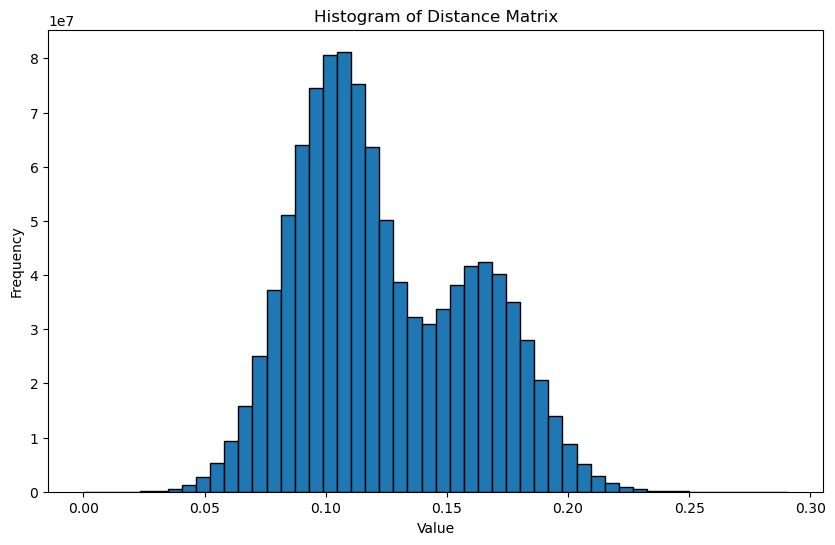

In [35]:
plot_histogram(distance_matrix, bins=50)

adj_path = generate_file_path("data/Dist_matrix("+32469+").npy")
adj = np.load(adj_path)

In [37]:
adj = distance_matrix

In [52]:
g = matrix_to_graph_tool(adj)

In [53]:
g.get_vertices()

array([    0,     1,     2, ..., 32466, 32467, 32468])

In [54]:
status_property = g.new_vertex_property('int')

In [55]:
for i, vertex in enumerate(g.vertices()):
    status_property[vertex] = int(df_sample['Status'].iloc[i])

In [56]:
# 创建一个列表，保存每个顶点的status_property的值
status_values = [status_property[v] for v in g.vertices()]

# 使用Counter来计算每个独特值的个数
value_counts = Counter(status_values)

# 打印结果
for value, count in value_counts.items():
    print(f"Value {value}: {count} occurrences")

Value 1: 12228 occurrences
Value 0: 20241 occurrences


In [57]:
tree = min_spanning_tree(g, weights=g.ep.edge_weight)
g.set_edge_filter(tree)

In [ ]:
# 融合矩阵
pairwise = pd.melt(pd.DataFrame(adj))

# 按值排序
ordered = pairwise.sort_values(by=['value'])

# 过滤掉所有值为0的行
non_zero = ordered.apply(lambda row: all(row != 0), axis=1)
final = ordered[non_zero]

# 查看最终结果的摘要和前几行
summary = final['value'].describe()
head = final.head()

print(summary)
print(head)

# Compute Gowers distance

Gower's distance is a measure of similarity between two data objects in a dataset. It was proposed by J.C. Gower in 1971 and is particularly useful when dealing with mixed data types, such as datasets that have a combination of numerical and categorical data.

Gower's distance calculates the similarity between objects based on a radial basis function between each variable of the objects. For numerical variables, the individual variable difference between two objects is divided by the range of that variable. For categorical variables, the difference is 0 if the category is the same and 1 otherwise. The individual similarities are then combined into an overall similarity.


If you're dealing with datasets that are purely numerical or categorical, there are other distance measures that might be more appropriate:

For numerical data, you can use Euclidean distance, Manhattan distance, or Minkowski distance. These are available in the scipy.spatial.distance module.

For categorical data, you can use Hamming distance or Jaccard similarity. Hamming distance is available in the scipy.spatial.distance module, and Jaccard similarity can be calculated using the sklearn.metrics.jaccard_score function.

Remember, the choice of distance measure can significantly impact the results of your analysis, so it's important to understand the properties of each measure and choose the one that's most appropriate for your data.

## Compute adjacency, distance matrix

In [37]:
# Usage
# Define the file path for the distance matrix
sample_data_path = generate_file_path("data/Bondora_sample("+str(num_default_samples*2)+").feather")
df_sample = pd.read_feather(sample_data_path)
print(sample_data_path)

/Users/yil1/p2p-model-bondora/data/Bondora_sample(24000).feather


In [ ]:
dist_matrix_path = generate_file_path("data/Dist_matrix("+str(num_default_samples*2)+").npy")
print(dist_matrix_path)
distance_matrix = calculate_and_save_gowers_distance(df_sample, dist_matrix_path)

In [39]:
distance_matrix

array([[0.        , 0.16073741, 0.16187109, ..., 0.15937716, 0.15014191,
        0.1440083 ],
       [0.16073741, 0.        , 0.14556302, ..., 0.08173035, 0.09980128,
        0.08579823],
       [0.16187109, 0.14556302, 0.        , ..., 0.19736263, 0.11842113,
        0.08599633],
       ...,
       [0.15937716, 0.08173035, 0.19736263, ..., 0.        , 0.12556161,
        0.12544167],
       [0.15014191, 0.09980128, 0.11842113, ..., 0.12556161, 0.        ,
        0.05349661],
       [0.1440083 , 0.08579823, 0.08599633, ..., 0.12544167, 0.05349661,
        0.        ]], dtype=float32)

In [40]:
distance_matrix.shape

(24000, 24000)

In [66]:
type(distance_matrix)

numpy.ndarray

What we have now:

df_sample

distance_matrix

# Sample segment

In [95]:
train_indices, validation_indices, test_indices = data_sampling(df_sample)
print(f"Train indices: {train_indices}")
print(f"Validation indices: {validation_indices}")
print(f"Test indices: {test_indices}")

Train indices: [ 4043 14260 17854 ...  2452 22316   940]
Validation indices: [ 8416 15510 11013 ...  8599  1879 21192]
Test indices: [  725 10861  6246 ...  2181 18417  4547]


train_indices

validation_indices

test_indices

In [97]:
train_indices

array([ 4043, 14260, 17854, ...,  2452, 22316,   940])

In [98]:
train_indices_d, train_indices_nd = indices_dnd(df_sample, train_indices)

train_indices_d

train_indices_nd

validation_indices

test_indices

In [103]:
len(
    set(
        np.concatenate((train_indices_d, train_indices_nd, validation_indices,
                        test_indices))))

24000

# Add centrality measures
more on graph-tools.
https://robert-haas.github.io/gravis-docs/code/examples/external_tools/graph-tool.html

In [19]:
# Load adjacency matrix
# The adjacency matrix is a square matrix used to represent a finite graph.
# The elements of the matrix indicate whether pairs of vertices are adjacent or not in the graph.
adj_path = generate_file_path("data/Dist_matrix("+str(num_default_samples*2)+").npy")
adj = np.load(adj_path)

Explain: Here, this graph is a fully connected, which means each pair of nodes has an edge. Thus, the Adjacency Matrix is equivalent to the Gower's Distance Matrix.

(When a graph is not fully connected, these two matrix are not equivalent any more.)

In [22]:
# Convert adjacency matrix to graph
# The adjacency matrix is then converted into a graph object using the `matrix_to_graph_tool` function.
# This function takes the adjacency matrix as input and returns a graph object that can be manipulated using the `graph-tool` library.
g = matrix_to_graph_tool(adj)

Attention here! We can use alpha threathold here!

In [23]:
# Calculate minimum spanning tree and set as edge filter
# A minimum spanning tree (MST) of a graph is a subset of the edges of the graph that connects all the vertices together,
# without any cycles and with the minimum possible total edge weight.
# The `min_spanning_tree` function from the `graph-tool` library is used to calculate the MST.
# The resulting MST is then set as an edge filter on the graph using `g.set_edge_filter(tree)`.
# This means that only the edges that are part of the MST will be considered in subsequent operations on the graph.
tree = min_spanning_tree(g, weights=g.ep.edge_weight)
g.set_edge_filter(tree)

In [54]:
g

<Graph object, directed, with 24000 vertices and 23999 edges, 1 internal edge property, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x2ab455e80, at 0x17ff403a0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x2ab455e80, at 0x17ab72c10>, False), at 0x2ab455e80>

In [24]:
# Calculate centrality measures
# Finally, several centrality measures are calculated for the graph using the `calculate_centrality_measures` function.
# Centrality measures provide a way of identifying the most important vertices within a graph.
# They are commonly used in network analysis to determine the relative importance of a vertex within the graph.
# The resulting centrality measures are stored in a DataFrame.
centrality_df = calculate_centrality_measures(g)

In [25]:
centrality_df

,pagerank,betweenness,closeness,eigenvector,katz,authority,hub
0,0.000023,0.0,8.902073,NaN,0.006453,0.000000e+00,2.078653e-22
1,0.000023,0.0,15.976149,NaN,0.006453,0.000000e+00,2.410830e-83
2,0.000023,0.0,13.396533,NaN,0.006453,0.000000e+00,6.701703e-47
3,0.000023,0.0,7.359868,NaN,0.006453,0.000000e+00,3.883548e-67
4,0.000023,0.0,26.029100,NaN,0.006453,0.000000e+00,1.762067e-95
...,...,...,...,...,...,...,...
23995,0.000127,0.0,NaN,NaN,0.006456,6.289251e-103,0.000000e+00
23996,0.000078,0.0,NaN,NaN,0.006454,3.161870e-142,0.000000e+00
23997,0.000184,0.0,NaN,NaN,0.006455,5.968064e-126,0.000000e+00
23998,0.000034,0.0,NaN,NaN,0.006454,4.234108e-49,0.000000e+00


In [57]:
type(centrality_df)

pandas.core.frame.DataFrame

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

def plot_histogram(df, column):
    """
    对于每列，绘制直方图。
    如果这一列全是NaN，输出警告并跳过。
    """
    if df[column].isna().all(): # 如果列全是NaN值，输出警告并跳过
        print(f"Warning: Column {column} only contains NaN values. Skipping...")
        return

    plt.figure()
    sns.histplot(df[column], kde=False, bins=50) # 限制bins数量为50
    plt.title(f"Histogram of {column}")
    plt.xlabel(column)
    plt.ylabel('Frequency')

centrality_data_path = generate_file_path("graph/Bondora_centrality_sample("+str(num_default_samples*2)+").pdf")

with PdfPages(centrality_data_path) as pdf: # 输出至PDF
    for column in centrality_df.columns:
        plot_histogram(centrality_df, column)
        if plt.get_fignums():  # 检查是否有活动的figure
            pdf.savefig()  # 将当前figure保存到pdf中
            plt.close()    # 关闭当前figure


## Combine ans save files

In [27]:
# Load original dataset
sample_data_path = generate_file_path("data/Bondora_sample("+str(num_default_samples*2)+").feather")
df_sample = pd.read_feather(sample_data_path)
print(sample_data_path)

# Merge with original dataset
df_sample_with_centrality = pd.concat([df_sample, centrality_df], axis=1)

/Users/yil1/p2p-model-bondora/data/Bondora_sample(24000).feather


In [28]:
df = df_sample_with_centrality

# Define the text file path
txt_file_path = generate_file_path("data//Bondora_sample("+str(num_default_samples*2)+")_with_centrality.csv")
print(txt_file_path)
# Write the DataFrame to the text file
df.to_csv(txt_file_path, sep=',', index=False)

/Users/yil1/p2p-model-bondora/data//Bondora_sample(24000)_with_centrality.csv
